# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



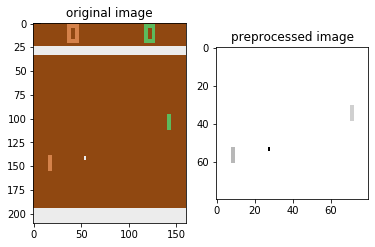

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        self.convs = nn.Sequential(
                # 2x80x80
                nn.Conv2d(2, 8, kernel_size=3, bias=False),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(),
                # 8x78x78
                nn.Conv2d(8, 12, kernel_size=4, stride=2, bias=False),
                nn.BatchNorm2d(12),
                nn.LeakyReLU(),
                # 12x36x36
                nn.MaxPool2d(2, 2),
                #12x18x18
                nn.Conv2d(64, 64, kernel_size=4, stride=2, bias=False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                #64x9x9
            )


        self.size=64 * 9 * 9

        self.fcs = nn.Sequential(
                nn.Linear(self.size, 32),
                # Pr(left) = 1.0 - Pr(right)
                nn.Linear(32, 1)
            )
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.size)
        return torch.sigmoid(self.fcs(x))


# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [5]:
#pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):
    
    # Turn everything to tensor
    states = torch.tensor(states, dtype=torch.float32, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    
    # Normalize rewards and compute future ones
    rewards = torch.tensor([ (gamma**idx) * R for idx, R in enumerate(rewards) ], dtype=torch.float32, device=device)
    mean = rewards.mean()
    std = rewards.std()
    rewards = (rewards - mean) / std

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    # Compute probability ratio and clip it
    ratio = None
    with torch.no_grad():
        # Probs of actions actually taken over probs of actions to take
        ratio = new_probs / old_probs
        
    # eps is small as we expect both probabilites to be the same
    clipped_ratio = torch.min(ratio, torch.clip(ratio, 1.0 - epsilon, 1.0 + epsilon))

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs * torch.log(old_probs + 1.e-10) + (1.0 - new_probs) * torch.log(1.0 - old_probs + 1.e-10))

    return torch.mean(beta * entropy + rewards * clipped_ratio)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        # The old probabilities are from the older policy, before the update
        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon *= .999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta *= .995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e + 1) % 20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e + 1)
    
timer.finish()

Episode: 20, score: -15.000000
[-17. -17. -12. -15. -13. -16. -16. -14.]


Episode: 40, score: -14.000000
[-16. -16. -10. -16. -15.  -7. -16. -16.]


Episode: 60, score: -14.125000
[-13. -14. -17. -16. -11. -13. -14. -15.]


Episode: 80, score: -14.125000
[-15. -16. -14. -16.  -7. -14. -15. -16.]


Episode: 100, score: -12.750000
[-16. -12. -11. -11. -14. -11. -11. -16.]


Episode: 120, score: -15.375000
[-16. -15. -16. -16. -16. -12. -16. -16.]


Episode: 140, score: -14.750000
[-15. -15. -15. -15. -13. -14. -15. -16.]


Episode: 160, score: -14.500000
[-14. -16. -12. -13. -15. -15. -15. -16.]


Episode: 180, score: -13.125000
[ -9. -14. -12. -16. -13. -16. -16.  -9.]


Episode: 200, score: -13.125000
[-14. -13. -13. -15. -12. -10. -14. -14.]


Episode: 220, score: -12.625000
[-13. -14. -12. -13. -15. -11. -12. -11.]


Episode: 240, score: -10.750000
[-12. -12.  -8.  -9.  -9. -10. -13. -13.]


Episode: 260, score: -8.750000
[-10.  -4.  -9.  -9.  -9.  -9. -12.  -8.]


Episode: 280, score: -8.750000
[-11. -10.  -6. -13.  -8. -14.  -4.  -4.]


Episode: 300, score: -7.875000
[ -7. -10.  -8.  -5.  -9.  -7. -10.  -7.]


Episode: 320, score: -5.625000
[-10.  -9.  -9.  -1.  -5.  -2.  -2.  -7.]


Episode: 340, score: -2.625000
[-7. -1. -8.  0. -1. -2. -1. -1.]


Episode: 360, score: -2.500000
[-1. -1. -7. -4. -4. -1. -2.  0.]


Episode: 380, score: -0.875000
[ 1. -1. -2. -1. -1. -1. -1. -1.]


Episode: 400, score: -1.500000
[-1. -5. -1. -1. -1. -1. -1. -1.]


Episode: 420, score: -1.375000
[ 0. -1. -1. -5. -2. -1. -1.  0.]


Episode: 440, score: -1.250000
[-1. -1. -1. -1. -1.  0. -5.  0.]


Episode: 460, score: -1.250000
[ 0. -1. -1. -3.  1. -3. -2. -1.]


Episode: 480, score: -0.375000
[ 0.  0. -2.  0. -2.  1.  0.  0.]


Episode: 500, score: 1.750000
[ 2.  1.  4.  5.  3. -1. -2.  2.]


In [8]:
pong_utils.play(env, policy, time=200) 

TypeError: a bytes-like object is required, not 'str'

In [ ]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 